In [1]:
import rml
import tadasets
import gudhi                as gd
import matplotlib.pyplot    as plt
import numpy                as np
import warnings
from scipy.optimize         import newton
from sklearn.neighbors      import KDTree
from scipy.sparse           import csr_matrix
from scipy.sparse.csgraph   import dijkstra
from sklearn.decomposition  import PCA
warnings.filterwarnings("ignore")


In [2]:
swiss = tadasets.swiss_roll(n=2000)
swiss = swiss[:, [1, 2, 0]]

sphere = tadasets.dsphere(n=1000, d=2)  # 3-sphere

pointx = np.random.uniform(size=[1000, 1])
pointy = np.random.uniform(size=[1000, 1])
point = np.hstack([pointx, pointy, np.zeros([1000, 1])])

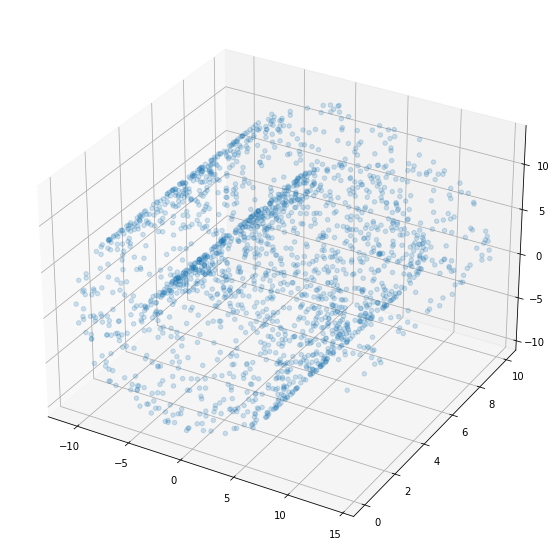

In [3]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')
ax.scatter3D(swiss[:, 0], swiss[:, 1], swiss[:, 2], alpha=0.2)

#ax.scatter3D(swiss[[831], 0], swiss[[831], 1], swiss[[831], 2], color='black')
#ax.scatter3D(swiss[[360, 704, 659, 824, 193], 0], swiss[[360, 704, 659, 824, 193], 1], swiss[[360, 704, 659, 824, 193], 2], color='r')
#ax.scatter3D(swiss[[824], 0], swiss[[824], 1], swiss[[824], 2], color='g')

In [3]:
S = rml.Simplex()
S.build_simplex(point, k=10, threshold_var=0.08, edge_sen=1)

#p_idx, computed_points, idx, pred, computed_points_b = S.normal_coords()
e = S.normal_coords()
#computed_points0 = [i for i in computed_points.keys() if computed_points[i]]

p_idx : 792
Restricted license - for non-production use only - expires 2023-10-25
826


In [13]:
point.shape

(1000, 3)

In [10]:
E = S.coords[e]
EE = S.pointcloud[e]

In [7]:
E.shape

(173, 2)

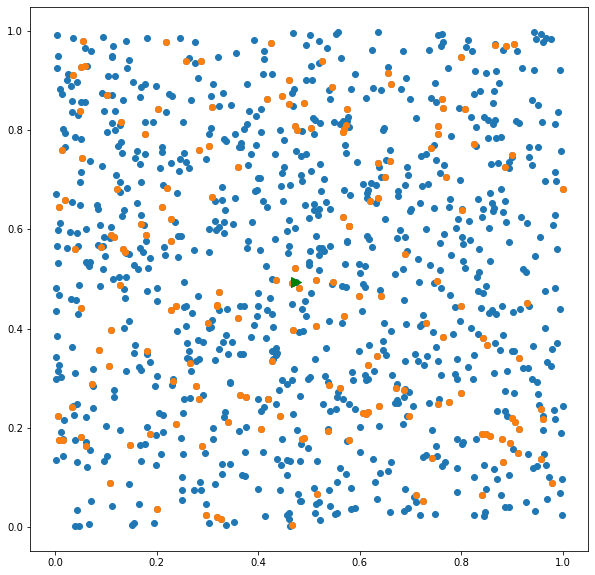

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(point[:,0], point[:, 1])
plt.scatter(EE[:, 0], EE[:, 1])
plt.scatter(point[792,0], point[792, 1], marker='>', color='g', s=100)

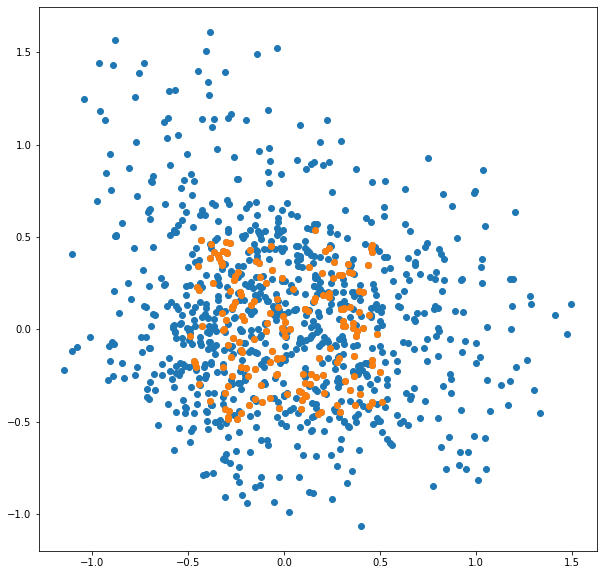

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(S.coords[:, 0], S.coords[:, 1])
plt.scatter(E[:, 0], E[:, 1])

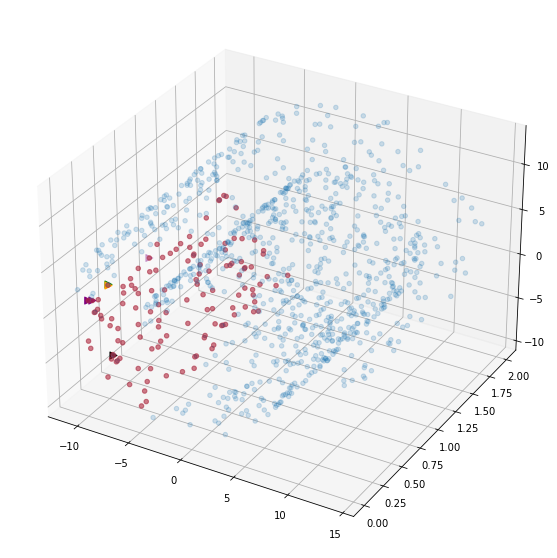

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')
ax.scatter3D(swiss[:, 0], swiss[:, 1], swiss[:, 2], alpha=0.2)

ax.scatter3D(swiss[[p_idx], 0], swiss[[p_idx], 1], swiss[[p_idx], 2], color='black', marker= '>', s=50)  # p
ax.scatter3D(swiss[[idx], 0], swiss[[idx], 1], swiss[[idx], 2], color='g', marker= '>', s=50)  # new point
ax.scatter3D(swiss[[pred], 0], swiss[[pred], 1], swiss[[pred], 2], color='orange', marker= '>', s=50)  # predecessor
ax.scatter3D(swiss[[computed_points_b], 0], swiss[[computed_points_b], 1], swiss[[computed_points_b], 2], color='purple', marker= '>', s=50) 


ax.scatter3D(swiss[[computed_points0], 0], swiss[[computed_points0], 1], swiss[[computed_points0], 2], color='r', alpha=0.5)


#ax.scatter3D(swiss[[360, 704, 659, 824, 193], 0], swiss[[360, 704, 659, 824, 193], 1], swiss[[360, 704, 659, 824, 193], 2], color='r')
#ax.scatter3D(swiss[[824], 0], swiss[[824], 1], swiss[[824], 2], color='g')

In [64]:
print(computed_points_b)
print(idx)
print(pred)
S.edges[pred]

[868, 234, 518]
401
929


array([401, 868, 234, 518])

In [65]:
S.edges[idx]

array([929, 747, 868, 625, 915])

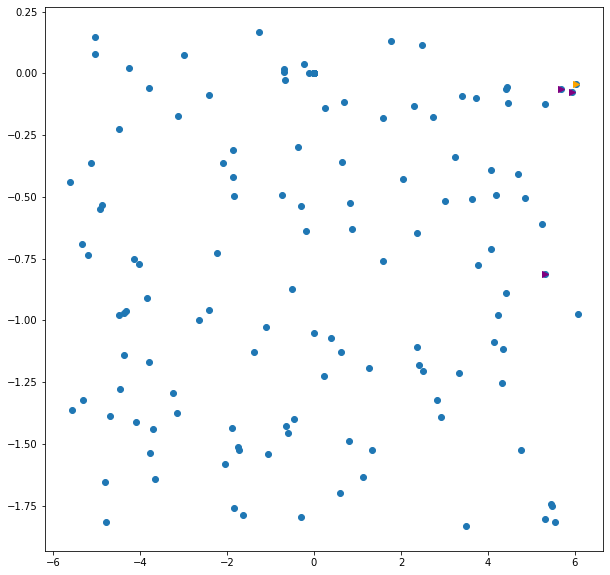

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(S.coords[:, 0], S.coords[:, 1])
plt.scatter(S.coords[pred, 0], S.coords[pred, 1], color='orange', marker='>')
plt.scatter(S.coords[computed_points_b, 0], S.coords[computed_points_b, 1], color='purple', marker='>')

In [9]:
def naive_solve(x, beta, sigmas, alpha):
        """
        Provides the function to solve for 'naive' normal 
        coordinates.

        Parameters
        ----------
        x : float
            Value of lambda to solve for.
        beta : (self.dim,) np.array
            Represents U^Tb.
        sigmas : (self.dim,) np.array
            Array of A's singular values.
        alpha : float
            Represents ||q-b||.
        """
        sigmas_squared = sigmas ** 2
        beta_squared = beta ** 2
        denom = (sigmas_squared+x)**2
        out = np.sum(beta_squared * sigmas_squared * (1/denom))
        return out - alpha ** 2

In [67]:
q = S.pointcloud[idx]
b = S.pointcloud[pred]
b_prime = S.coords[pred]
k = len(computed_points_b)

In [68]:
alpha = np.linalg.norm(q-b)  # ||q-b||

y = S.pointcloud[computed_points_b] - b  # rows are c_i-b
y /= np.linalg.norm(y, axis=1).reshape(k, 1)
y /= alpha
y *= q-b
y = np.sum(y, axis=1)  # 1-D np.array

In [69]:
A = S.coords[computed_points_b] - b_prime  # (k, dim) then U (with full_matrices=False) gives (k, dim) for U and U^Tb has (dim,)
A /= np.linalg.norm(A, axis=1).reshape(k, 1)
A /= alpha

In [70]:
A.shape

(3, 2)

In [71]:
U, sigmas, _ = np.linalg.svd(A, full_matrices=False)
beta = U.T @ y

In [75]:
x = newton(naive_solve, 0, args=(beta, sigmas, alpha))  # set x0=0 from paper
normal_coord = np.linalg.inv(A.T @ A + x * np.eye(S.dim)) @ A.T @ y + b_prime
#self.coords[idx] = normal_coord

RuntimeError: Tolerance of 1.655956914801953e+26 reached. Failed to converge after 9 iterations, value is 1.6559569147924093e+26.

In [67]:
normal_coord

array([-3.15231209, -2.78159742])

In [78]:
import gurobipy as gp
from gurobipy import GRB

In [80]:
m = gp.Model()
m.setParam('OutputFlag', 0)
m.setParam(GRB.Param.NonConvex, 2)
x = m.addMVar(shape=2, lb=float('-inf'))

Q = A.T @ A
c = -2 * y.T @ A

obj = x @ Q @ x + c @ x + y.T @ y
m.setObjective(obj, GRB.MINIMIZE)
m.addConstr(x@x == alpha, name="c")
m.optimize()
print(x.X)
print('Obj: %g' % m.ObjVal)

[-0.06514449  0.25034633]
Obj: 4.56253


In [82]:
normal_coord = x.X + b_prime

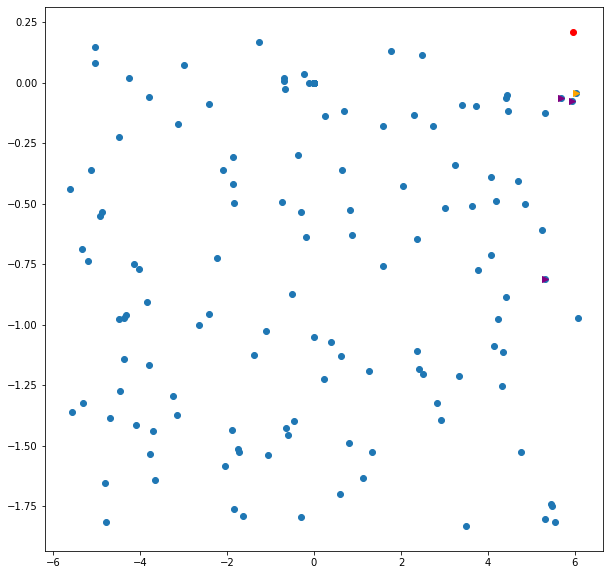

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(S.coords[:, 0], S.coords[:, 1])
plt.scatter(S.coords[pred, 0], S.coords[pred, 1], color='orange', marker='>')
plt.scatter(S.coords[computed_points_b, 0], S.coords[computed_points_b, 1], color='purple', marker='>')

plt.scatter(normal_coord[0], normal_coord[1], color='r')